In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import warnings
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

# Use True if you dont have your own data
USE_DEMO_DATA = True

# Specify if you have your own data
TRAIN_DATA_PATH = 'YOUR_TRAIN_DATA_PATH'
TEST_DATA_PATH = 'YOUR_TEST_DATA_PATH'

if USE_DEMO_DATA:
    # making demo data for 2 categories
    df = pd.read_json('../data/dataset.json')
    cat_2_df = df.copy()
    cat_2_df['category_id'] = 2
    train_1, test_1 = train_test_split(df, shuffle=True, random_state=42, test_size=0.078)
    train_2, test_2 = train_test_split(cat_2_df, shuffle=True, random_state=42, test_size=0.078)
    
    train_df = pd.concat([train_1, train_2]).reset_index(drop=True)
    test_df = pd.concat([test_1, test_2]).reset_index(drop=True)
else:
    # reading your data
    train_df = pd.read_json(TRAIN_DATA_PATH)
    test_df = pd.read_json(TEST_DATA_PATH)
    
train_df.head()

/Users/asgatakmaev/miniconda3/envs/recsys/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,category_id,published_date,price,update_stat_date,refreshed_date,view_count,is_sticky,item_origin,extended_guarantee,nsb,...,steam_cs2_ban_type,steam_rust_kill_player,steam_rust_deaths,steam_total_gifts_rub,steam_total_refunds_rub,steam_total_ingame_rub,steam_total_games_rub,steam_total_purchased_rub,steam_dota2_last_match_date,sold_price
0,1,1695058353,360,1695227440,1695058353,9,0,fishing,-1,1,...,0,0,0,0,0,0,0,0,0,360
1,1,1689775707,115,0,1689775707,8,0,brute,0,1,...,0,0,0,0,0,0,0,0,0,115
2,1,1694338912,145,0,1695842027,71,0,autoreg,1,1,...,0,0,0,0,0,0,0,0,0,145
3,1,1694791149,649,0,1694791149,59,0,resale,0,0,...,0,0,0,0,0,0,0,0,0,649
4,1,1695738971,40,1695847124,1695738971,10,0,brute,0,1,...,0,0,0,0,0,0,0,0,0,40


In [2]:
unique_categories = train_df['category_id'].unique()

print(unique_categories)

[1 2]


#### Splitting data into separate catogories by category_id

In [3]:
categories_dfs = {}

for category in tqdm(unique_categories):
    category_df = train_df[train_df['category_id'] == category].copy()
    categories_dfs[category] = category_df
    
categories_dfs.keys()

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 11.02it/s]


dict_keys([1, 2])

## Training models for each category

In [4]:
from single_cat_model import SingleCategoryModel

categories_models = {}

for category in unique_categories:
    print("Training model for category", category, end='\n\n')
    model = SingleCategoryModel(category_number=category)
    
    model.train(categories_dfs[category])
    
    categories_models[category] = model

Training model for category 1

Initialized SingleCategoryModel for category 1.
0:	learn: 1133.1963847	test: 1032.8345186	best: 1032.8345186 (0)	total: 69.2ms	remaining: 1h 9m 10s
250:	learn: 186.9925554	test: 323.3734654	best: 323.3734654 (250)	total: 3s	remaining: 11m 53s
500:	learn: 120.8233257	test: 304.4416704	best: 303.9107791 (452)	total: 5.86s	remaining: 11m 35s
750:	learn: 91.7251694	test: 294.4507009	best: 294.4507009 (750)	total: 8.69s	remaining: 11m 25s
1000:	learn: 73.9268990	test: 290.2288304	best: 290.1990482 (999)	total: 11.6s	remaining: 11m 23s
1250:	learn: 62.6547363	test: 288.8670679	best: 288.8567202 (1248)	total: 14.4s	remaining: 11m 16s
1500:	learn: 54.9621009	test: 287.5083440	best: 287.5083440 (1500)	total: 17.3s	remaining: 11m 14s
1750:	learn: 49.0542570	test: 286.2480219	best: 286.2436965 (1746)	total: 20.2s	remaining: 11m 12s
2000:	learn: 44.2839464	test: 285.4388544	best: 285.4271142 (1987)	total: 23.2s	remaining: 11m 11s
2250:	learn: 40.5172431	test: 285.266

### Saving models to ONNX and CBM format

In [5]:
categories_models

{1: <single_cat_model.SingleCategoryModel at 0x10403d310>,
 2: <single_cat_model.SingleCategoryModel at 0x148ca3d10>}

In [6]:
for category in categories_models.keys():
    categories_models[category].export(output_path_onnx=f'./models/onnx/category_{category}_model.onnx')

Model exported to ./models/onnx/category_1_model.onnx
Model exported to ./models/onnx/category_2_model.onnx


## Validating model for each category

### Loading available models and validating on test data

In [7]:
from single_cat_model import SingleCategoryModel
import pandas as pd
import numpy as np

# categries you saved your models for
categories = [1, 2]

test_categories_dfs = {}

# splitting test set to separate categories
for category in categories:
    test_categories_dfs[category] = test_df[test_df['category_id'] == category]
    
metrics_dict = {}

for category in categories:
    
    # initializing empty model
    model = SingleCategoryModel(category_number=category)
    # loading saved weights
    model.load_model(f'./models/onnx/category_{category}_model.onnx') # using path to CBM format!
    # validating on test set
    metrics = model.validate(
        valid_df=test_categories_dfs[category], 
        save_plot_path=f'./validation_plots/cat_{category}_pearson.png'
    )
    
    # saving metrics
    metrics_dict[category] = metrics
    
    print('\n')

Initialized SingleCategoryModel for category 1.
Loaded the model from ./models/onnx/category_1_model.onnx

Regression Metrics:

Mean Absolute Error (MAE): 25.0373
Mean Squared Error (MSE): 157892.7961
Root Mean Squared Error (RMSE): 397.3573
R² Score: 0.9022
Pearson Correlation (Full Dataset): 0.9578
Pearson Correlation (Sample Size 100): 0.9997
Pearson Correlation (Sample Size 1000): 0.9962
Pearson Correlation (Sample Size 10000): 0.9578
Pearson correlation plot saved to ./validation_plots/cat_1_pearson.png


Initialized SingleCategoryModel for category 2.
Loaded the model from ./models/onnx/category_2_model.onnx

Regression Metrics:

Mean Absolute Error (MAE): 25.0373
Mean Squared Error (MSE): 157892.7961
Root Mean Squared Error (RMSE): 397.3573
R² Score: 0.9022
Pearson Correlation (Full Dataset): 0.9578
Pearson Correlation (Sample Size 100): 0.9988
Pearson Correlation (Sample Size 1000): 0.9019
Pearson Correlation (Sample Size 10000): 0.9578
Pearson correlation plot saved to ./valid

In [8]:
metrics_dict

{1: {'mae': 25.037282249779665,
  'mse': 157892.79612663962,
  'rmse': 397.3572650986007,
  'r2': 0.9021543294164768,
  'pearson_correlation_full': 0.9578366100725145,
  'sample_pearsons': {100: 0.999739883869432,
   1000: 0.996226093948104,
   10000: 0.957811627183642}},
 2: {'mae': 25.037282249779665,
  'mse': 157892.79612663962,
  'rmse': 397.3572650986007,
  'r2': 0.9021543294164768,
  'pearson_correlation_full': 0.9578366100725145,
  'sample_pearsons': {100: 0.9987652363284815,
   1000: 0.9019208641989378,
   10000: 0.957787210249377}}}

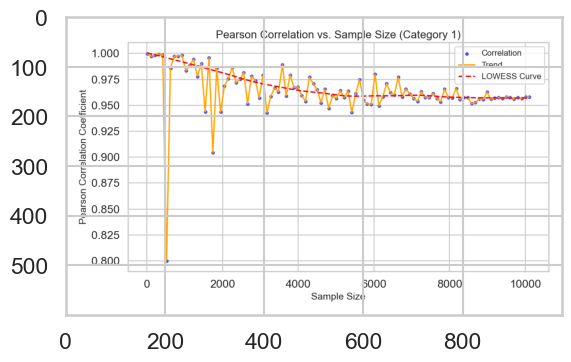

In [11]:
import matplotlib.pyplot as plt

plot = plt.imread('./validation_plots/cat_1_pearson.png')
plt.imshow(plot)

## Finetuning example

In [12]:
model.finetune(test_1)

metrics = model.validate(test_1, './validation_plots/finetuned_model_plot.png')

print(metrics)

Model shrinkage in combination with learning continuation is not implemented yet. Reset model_shrink_rate to 0.


An error occurred during finetuning: /Users/zomb-ml-platform-msk/go-agent-21.2.0/pipelines/BuildMaster/catboost.git/catboost/libs/train_lib/options_helper.cpp:386: Model shrinkage and Posterior Sampling in combination with learning continuation is not implemented yet.

Regression Metrics:

Mean Absolute Error (MAE): 25.0373
Mean Squared Error (MSE): 157892.7961
Root Mean Squared Error (RMSE): 397.3573
R² Score: 0.9022
Pearson Correlation (Full Dataset): 0.9578
Pearson Correlation (Sample Size 100): 0.9996
Pearson Correlation (Sample Size 1000): 0.9209
Pearson Correlation (Sample Size 10000): 0.9578
Pearson correlation plot saved to ./validation_plots/finetuned_model_plot.png
{'mae': 25.037282249779665, 'mse': 157892.79612663962, 'rmse': 397.3572650986007, 'r2': 0.9021543294164768, 'pearson_correlation_full': 0.9578366100725145, 'sample_pearsons': {100: 0.9995600286920105, 1000: 0.9208895510420332, 10000: 0.9577960999140724}}


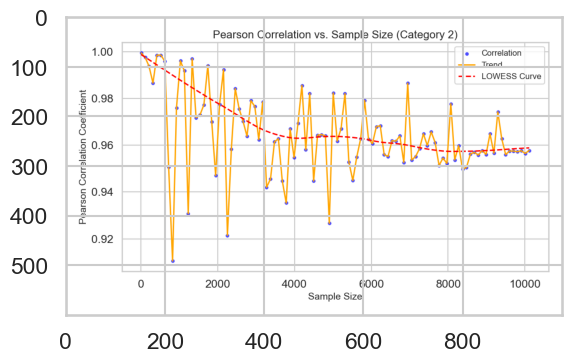

In [13]:
plot = plt.imread('./validation_plots/finetuned_model_plot.png')
plt.imshow(plot)